# PARCtorch

## Normalization

In [3]:
import sys

# Add the root directory (PARCTorch) to the system path
sys.path.append("/torch/torch/PARCtorch/PARCtorch")
sys.path.append("/torch/torch/PARCtorch")
from data.normalization import compute_min_max


In [4]:
# Example usage
data_dirs = ["/data/hmx/tn", "/data/hmx/tt"]
output_file = "/log/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

Calculating channel-wise min and max values for normalization...
Current working directory: /torch/torch/PARCtorch/PARCtorch/demos
Total files to process: 6
Processed 6/6 files.
Channel-wise min values: [300.0, -1068848000.0, 0.0, -1844.2911, -4740.4946]
Channel-wise max values: [5000.0, 60107620000.0, 1.0, 5536.8438, 5215.695]
Min and max values saved to '/log/hmx_min_max.json'.


## Create Data Loader for Training

In [5]:
# Now import the utilities
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
    InitialConditionDataset,
    initial_condition_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth

import torch
from torch.utils.data import DataLoader

# Set up logging
# logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# Example configuration for HMX dataset
data_dir_train = data_dirs[0]
data_dir_test = data_dirs[1]
future_steps = 1
# Path to the min_max.json file
min_max_path = output_file
batch_size = 1

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn)

Listing samples: 100%|██████████| 3/3 [00:00<00:00, 2943.37it/s]


## Visualize the Data was Laoded Properly

Channel Data Statistics:
Channel 0: IC min=0.0, IC max=0.0089606624096632
  Step 1: min=0.0, max=0.05388303101062775
Channel 1: IC min=0.0174715556204319, IC max=0.023915231227874756
  Step 1: min=0.0174715556204319, max=0.17028813064098358
Channel 2: IC min=0.0, IC max=1.0
  Step 1: min=0.0, max=1.0
Channel 3: IC min=0.24986553192138672, IC max=0.2897675931453705
  Step 1: min=0.24986553192138672, max=0.3853633999824524
Channel 4: IC min=0.4761354327201843, IC max=0.4761354327201843
  Step 1: min=0.4761354327201843, max=0.4761354327201843


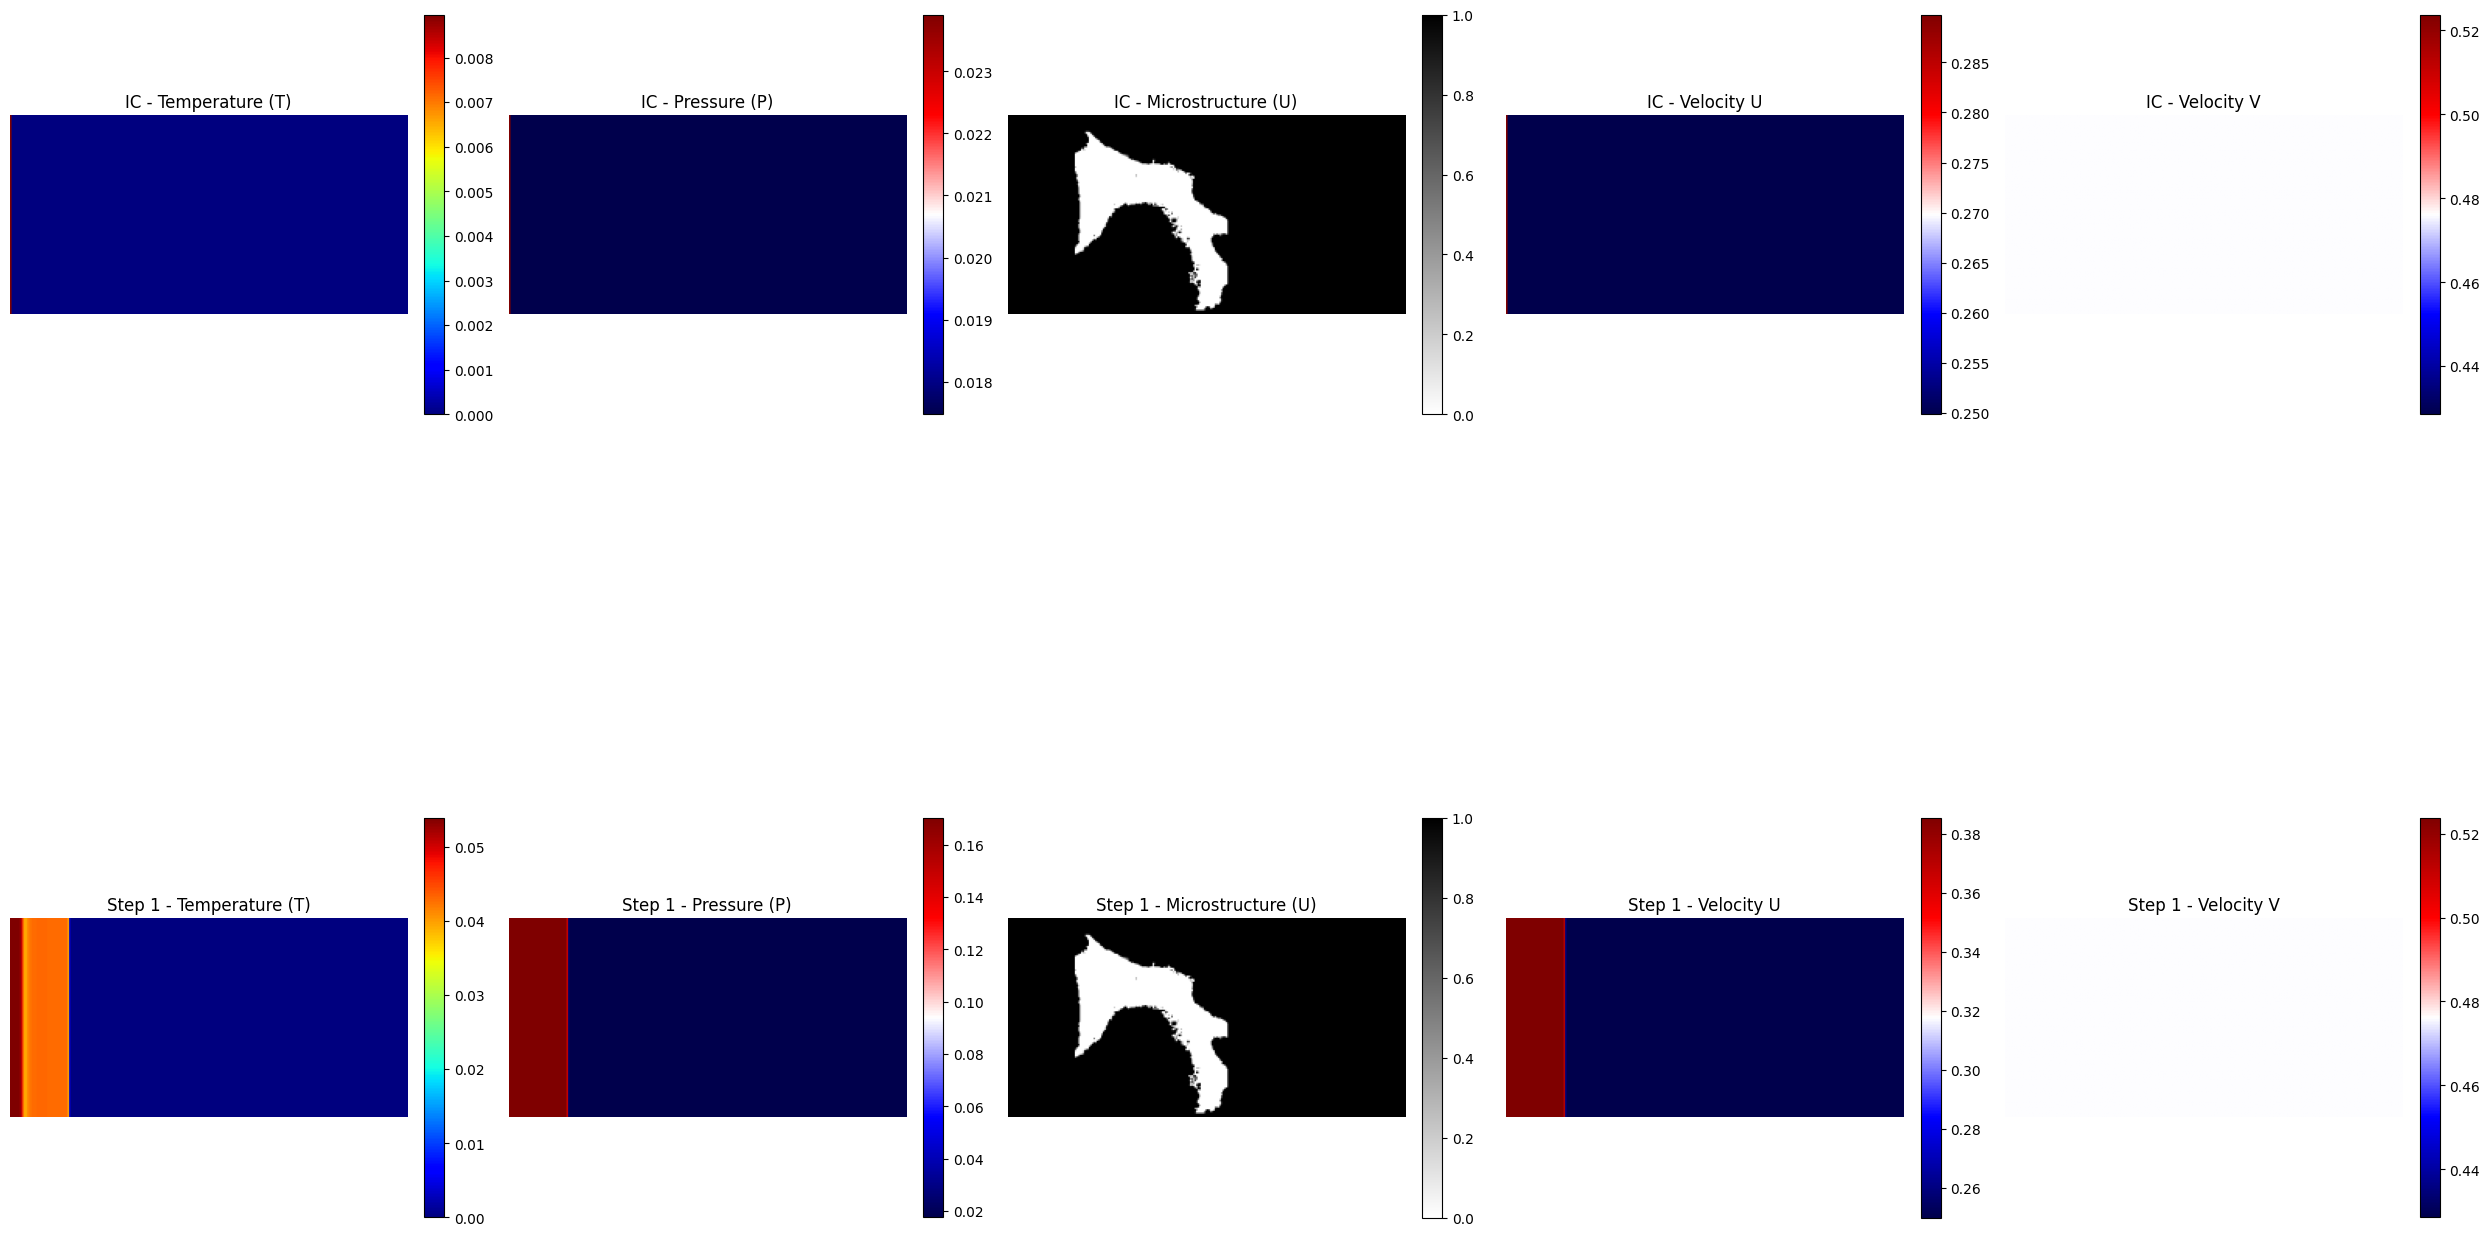

Channel Data Statistics:
Channel 0: IC min=0.0, IC max=0.05388303101062775
  Step 1: min=0.0, max=0.20860305428504944
Channel 1: IC min=0.0174715556204319, IC max=0.17028813064098358
  Step 1: min=0.012567500583827496, max=0.17030571401119232
Channel 2: IC min=0.0, IC max=1.0
  Step 1: min=0.0, max=1.0
Channel 3: IC min=0.24986553192138672, IC max=0.3853633999824524
  Step 1: min=0.23965571820735931, max=0.6809406280517578
Channel 4: IC min=0.4761354327201843, IC max=0.4761354327201843
  Step 1: min=0.1809128075838089, max=0.6584482192993164


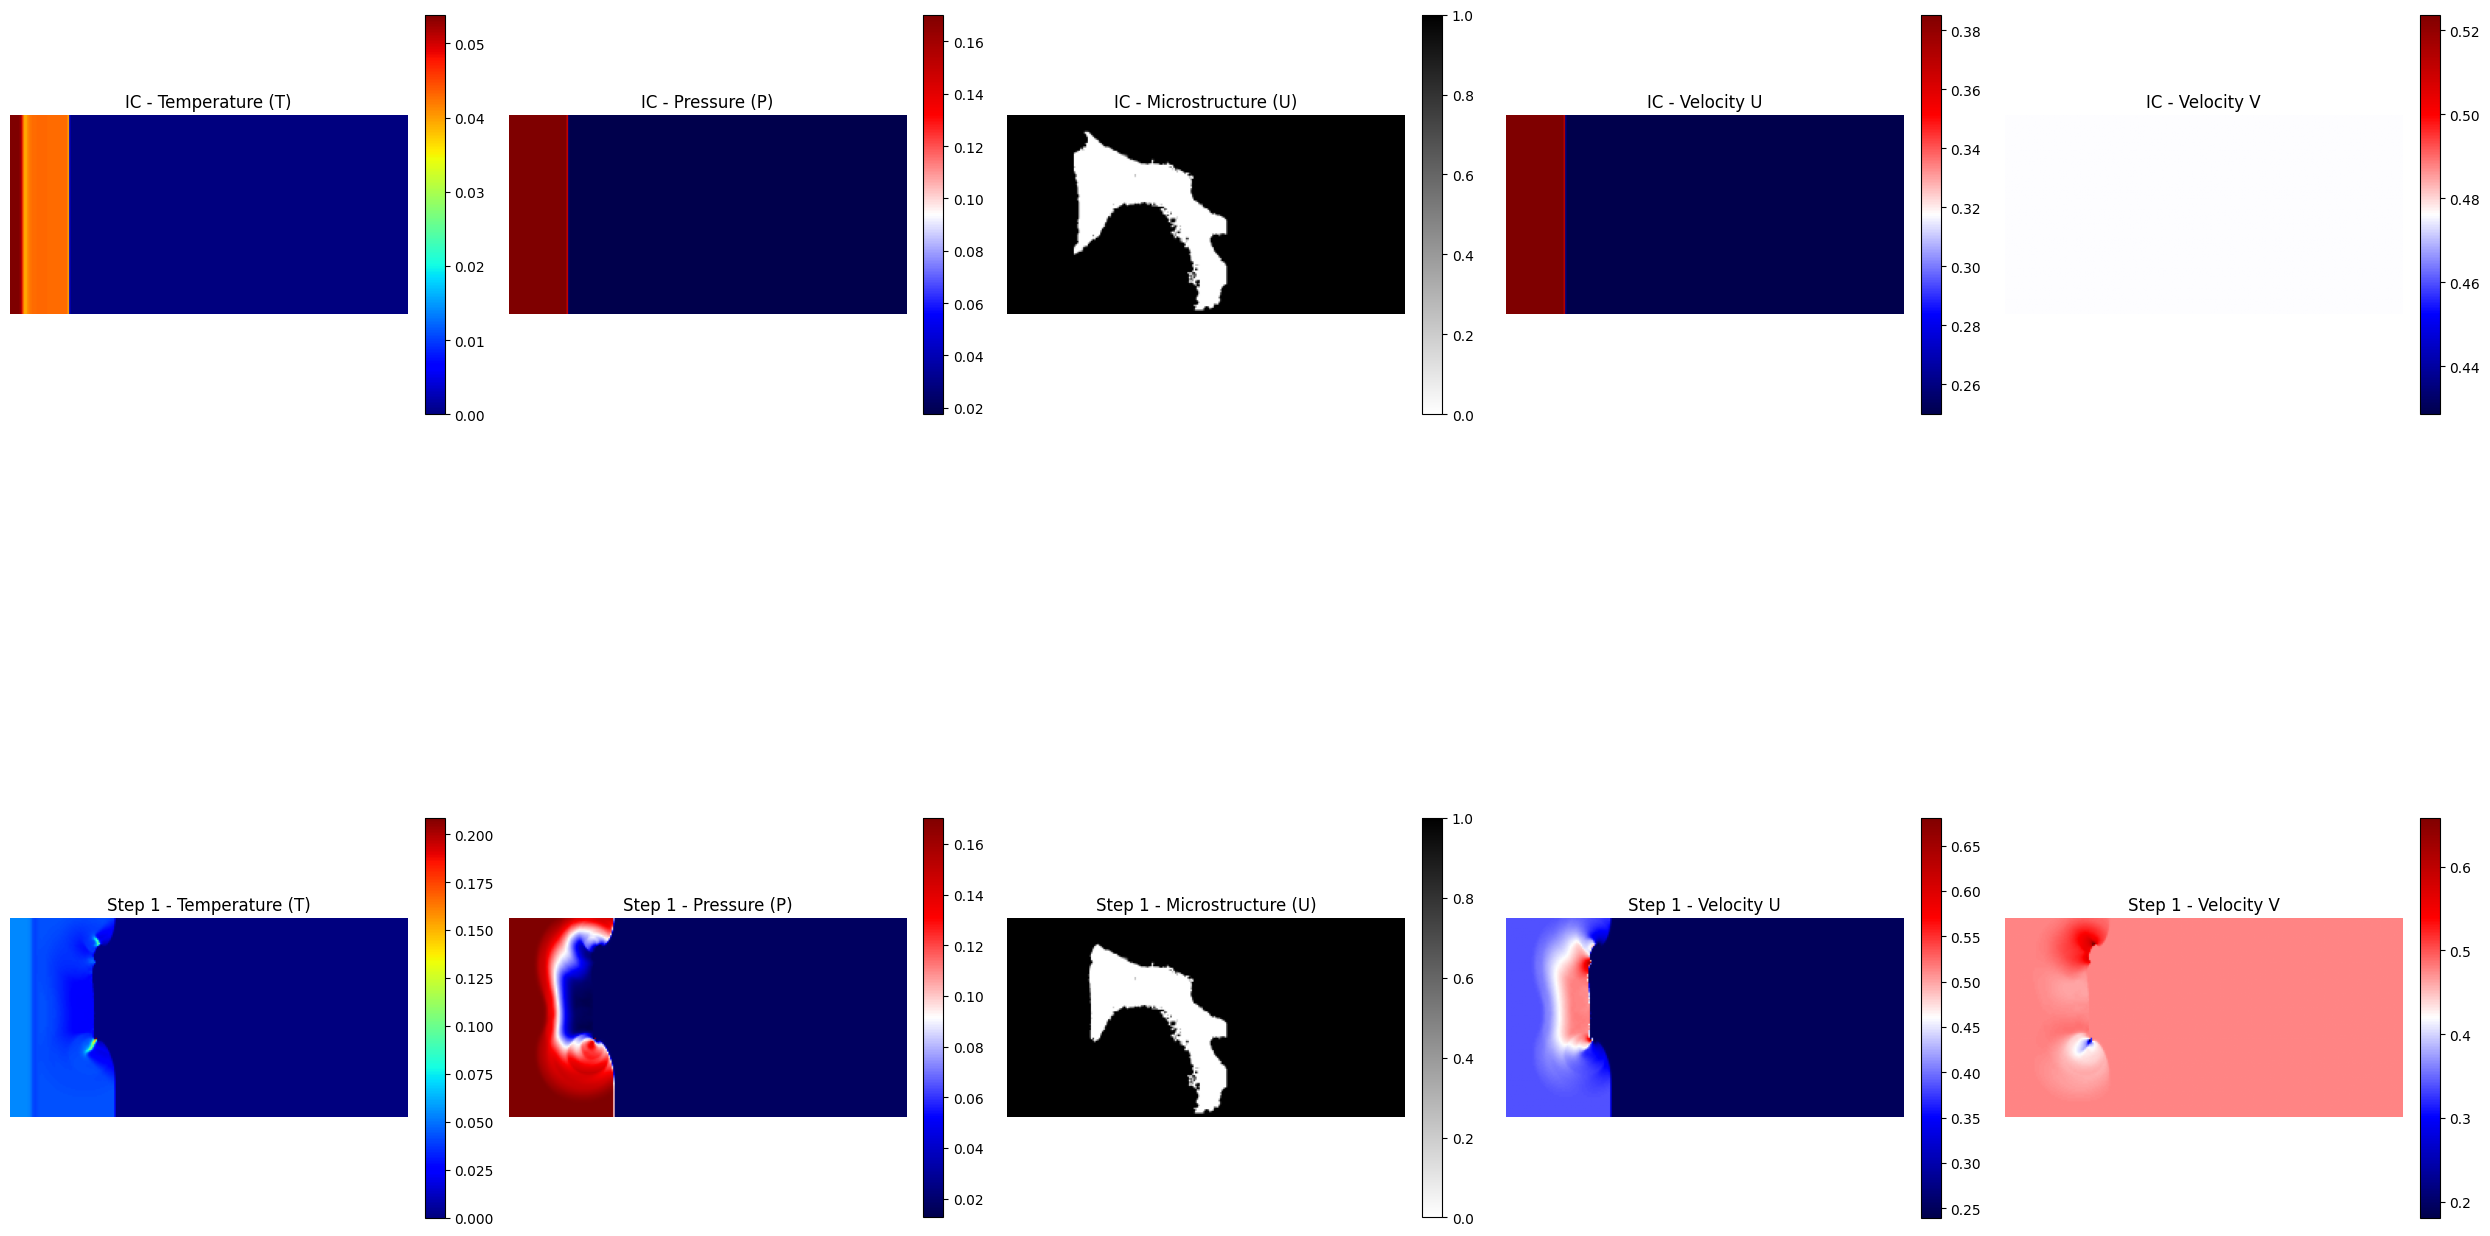

In [6]:
# Fetch a batch and visualize
for batch_idx, batch in enumerate(train_loader):
    ic, t0, t1, target = batch
    channel_names = [
        "Temperature (T)",
        "Pressure (P)",
        "Microstructure (U)",
        "Velocity U",
        "Velocity V",
    ]
    custom_cmaps = ["jet", "seismic", "binary", "seismic", "seismic"]

    visualize_channels(
        ic,
        t0,
        t1,
        target,
        channel_names=channel_names,
        channel_cmaps=custom_cmaps,
    )
    # Visualize one batch for now
    if batch_idx == 1: 
        break 

## Build your PARC Model

In [7]:
import sys

sys.path.append("../../")

In [8]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.differentiator import ADRDifferentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.rk4 import RK4
from PARCtorch.utilities.unet import UNet

In [9]:
from torch.optim import Adam

In [10]:
n_fe_features = 128
unet_em = UNet(
    [64, 64 * 2, 64 * 4, 64 * 8, 64 * 16],
    5,
    n_fe_features,
    up_block_use_concat=[False, True, False, True],
    skip_connection_indices=[2, 0],
    use_deform=True,       # ← turn on deformable conv
    deform_groups=1        # ← how many offset groups to predict (reference deformable conv for detais)
)


right_diff = FiniteDifference(padding_mode="replicate").cuda()
rk4_int = RK4().cuda()

diff_em = ADRDifferentiator(
    3,  # 3 state variables: T, p, mu. We always assume 2 velocity channels being the last 2 channels
    n_fe_features,  # Number of features returned by the feature extraction network: 128
    [0, 1, 2, 3, 4],  # Channel indices to calculate advection: all channels
    [0],  # Channel indices to calculate diffusion: T
    unet_em,  # Feature extraction network: unet_em
    "constant",  # Padding mode: constant padding of zero
    right_diff,  # Finite difference method: replicate image gradients, 
    spade_random_noise=True
).cuda()

ddi_list = [None] * 5

em_int = Integrator(
    True,  # Clip input data between 0 and 1
    [],  # No Poisson
    rk4_int,  # RK4 integration
    ddi_list,  # Data-driven integrators: 1 for each state variable and 1 for velocities
    "constant",  # Padding mode: constant padding of zero
    right_diff,  # Finite difference method: replicate image gradients
).cuda()

criterion = torch.nn.L1Loss().cuda()
model = PARCv2(diff_em, em_int, criterion).cuda()
optimizer = Adam(model.parameters(), lr=1e-5)

superclass reached
False
<class 'PARCtorch.differentiator.differentiator.ADRDifferentiator'> <class 'PARCtorch.integrator.integrator.Integrator'> <class 'torch.nn.modules.loss.L1Loss'>


## Train the Model 

## Load the Model

In [ ]:
from utilities.load import load_model_weights

# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights_path = (
    "/log/model.pth"  # Replace with your path
)
model = load_model_weights(model, model_weights_path, device)

Loaded model weights from '/log/model.pth'


## Create the Sequence DataLoader
### This will contain the t=0 for each test file

In [61]:
# Initialize the dataset
future_steps = 14
seq_dataset = InitialConditionDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
seq_loader = DataLoader(
    seq_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=initial_condition_collate_fn,
)

Validating files: 100%|██████████| 3/3 [00:00<00:00, 825.92it/s]


## Ground Truth Loader

In [62]:
# Initialize the dataset
gt_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
gt_loader = DataLoader(
    gt_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

Listing samples: 100%|██████████| 3/3 [00:00<00:00, 990.31it/s]


## Visualize the Results

Predictions shape: torch.Size([3, 1, 5, 128, 256])
Sample prediction for timestep 1: torch.Size([3, 5, 128, 256])


AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

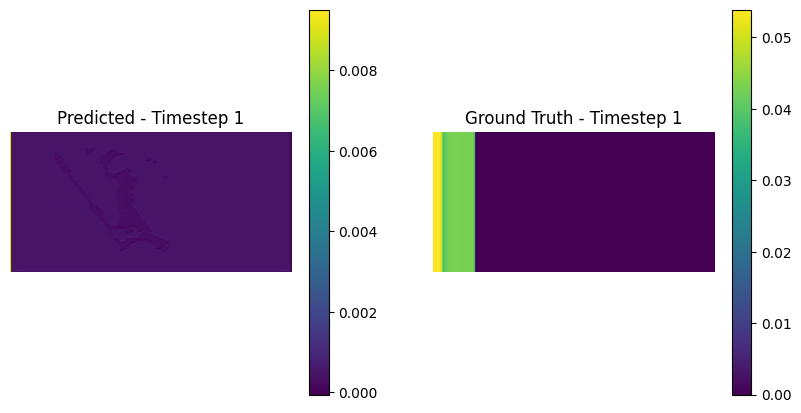

In [63]:
# Set the model to evaluation mode
model.eval()

# Define channel names and colormaps
channels = [
        "Temperature (T)",
        "Pressure (P)",
        "Microstructure (U)",
        "Velocity U",
        "Velocity V",
    ]  # Adjust as per your data
cmaps = ["jet", "seismic", "binary", "seismic", "seismic"]  # Adjust as per your preference

# Iterate through both DataLoaders simultaneously
for seq_batch, test_batch in zip(seq_loader, gt_loader):
    # Extract data from initial condition loader
    ic, t0, t1, _ = (
        seq_batch  # Shape: [batch_size, channels, height, width], scalar, tensor, _
    )

    # Extract data from ground truth loader
    gt_ic, gt_t0, gt_t1, ground_truth = (
        test_batch  # ground_truth shape: [timesteps, batch_size, channels, height, width]
    )

    # Move data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ic = ic.to(device)
    t0 = t0.to(device)
    t1 = t1.to(device)
    ground_truth = ground_truth.to(device)

    # Make predictions using the model
    with torch.no_grad():
        predictions = model(
            ic, t0, t1
        )  # Shape: [future_steps, batch_size, channels, height, width]

    print("Predictions shape:", predictions.shape)
    print(
        "Sample prediction for timestep 1:", predictions[:, 0, :, :, :].shape
    )

    # If you want to visualize more samples in the batch, loop through batch indices
    # For example, to visualize all samples in the batch:
    for batch_idx in range(ic.size(0)):
        save_gifs_with_ground_truth(
            predictions=predictions,
            ground_truth=ground_truth,
            channels=channels,
            cmaps=cmaps,
            filename_prefix=f"comparison_batch{batch_idx}",
            interval=400,
            batch_idx=batch_idx,
        )
        break

    break  # Remove this if you want to process the entire dataset